## **Libarires**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
 
import os
import glob
import pickle

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dataframe = pd.read_csv("/content/drive/MyDrive/combined_csv (1).csv")

In [ ]:
dataframe.head()

,File X,File Y,Map X,Map Y,Lat,Lon,B1,B2,B3,B4,B5,B6,class,Unnamed: 13,File X
0,384.0,166,290505,1197315,10.825246,79.083772,45,36,72,36,20,58,5.0,NaN,NaN
1,392.0,166,290745,1197315,10.825259,79.085966,45,40,56,37,21,51,5.0,NaN,NaN
2,393.0,166,290775,1197315,10.825261,79.086241,45,41,65,45,25,56,5.0,NaN,NaN
3,383.0,166,290475,1197315,10.825244,79.083498,45,37,77,41,23,60,5.0,NaN,NaN
4,391.0,167,290715,1197285,10.824986,79.085694,46,44,35,16,11,43,5.0,NaN,NaN


In [ ]:
band_1 = dataframe.iloc[:, 6:7].values
band_1

array([[  45],
       [  45],
       [  45],
       ...,
       [9706],
       [9705],
       [9573]])

In [ ]:
band_1.shape

(169527, 1)

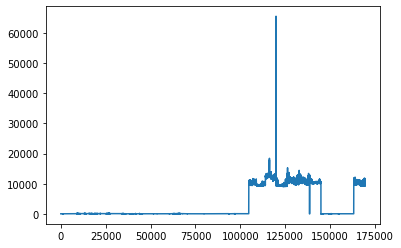

In [ ]:
plt.plot(band_1)

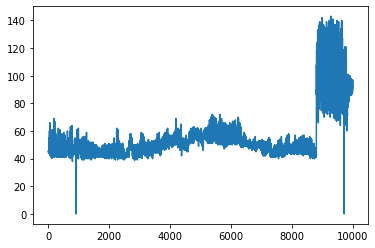

In [ ]:
plt.plot(band_1[:10000])

## **Scaling**

In [ ]:
sc = MinMaxScaler()
scaled_band = sc.fit_transform(band_1)

In [ ]:
print(sc.data_min_, sc.data_max_)

[0.] [65535.]


## **Prearing features and labels**

**Tranining metrics**

In [ ]:
time_scale = 60
batch_size = 128
no_epochs = 100

In [ ]:
X = []
y = []

for i in range(time_scale, len(scaled_band)):
  X.append(scaled_band[i-time_scale:i, 0])
  y.append(scaled_band[i, 0])
X, y = np.array(X), np.array(y)

## **Train and validation Split**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

## **Training Model**

In [ ]:
model = tf.keras.models.Sequential([
      tf.keras.layers.GRU(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.GRU(100, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.GRU(100, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.GRU(100),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1)
])

model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['mae', 'mse']
)

history = model.fit(
    X_train, y_train, 
    epochs=no_epochs, 
    batch_size=batch_size, 
    validation_data=(X_valid, y_valid),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10)]
)

Epoch 1/100
1060/1060 [==============================] - 92s 81ms/step - loss: 2.1882e-04 - mae: 0.0073 - mse: 2.1882e-04 - val_loss: 4.6023e-05 - val_mae: 0.0060 - val_mse: 4.6023e-05
Epoch 2/100
1060/1060 [==============================] - 85s 80ms/step - loss: 4.4398e-05 - mae: 0.0044 - mse: 4.4398e-05 - val_loss: 1.6728e-05 - val_mae: 0.0021 - val_mse: 1.6728e-05
Epoch 3/100
1060/1060 [==============================] - 85s 80ms/step - loss: 3.9834e-05 - mae: 0.0041 - mse: 3.9834e-05 - val_loss: 2.9237e-05 - val_mae: 0.0047 - val_mse: 2.9237e-05
Epoch 4/100
1060/1060 [==============================] - 84s 79ms/step - loss: 3.9512e-05 - mae: 0.0039 - mse: 3.9512e-05 - val_loss: 1.2536e-05 - val_mae: 0.0017 - val_mse: 1.2536e-05
Epoch 5/100
1060/1060 [==============================] - 84s 79ms/step - loss: 4.2963e-05 - mae: 0.0039 - mse: 4.2963e-05 - val_loss: 9.9394e-06 - val_mae: 0.0013 - val_mse: 9.9394e-06
Epoch 6/100
1060/1060 [==============================] - 85s 80ms/step - lo

## **Training curves**

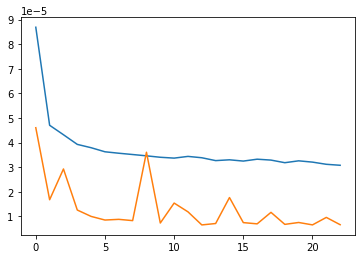

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

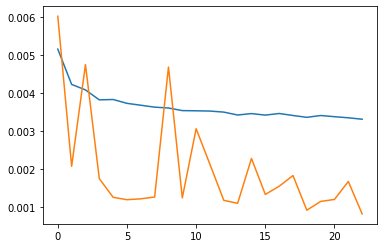

In [ ]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])

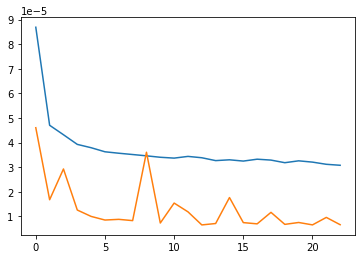

In [ ]:
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])

## **Training metrics**

In [ ]:
print("Training MAE: ", np.mean(history.history["mae"]))
print("Validation MAE: ", np.mean(history.history["val_mae"]))

print("Training MSE: ", np.mean(history.history["mse"]))
print("Validation MAE: ", np.mean(history.history["val_mse"]))

Training MAE:  0.00364341269976095
Validation MAE:  0.0019821440826332114
Training MSE:  3.7131239482930496e-05
Validation MAE:  1.3225810265715193e-05


## **Save model**

In [ ]:
model.save("/content/band_model.h5")

## **Downloading model**

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('/content/band_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Loading saved model from drive** 

```
# Only incase you have saved model in drive
```



In [ ]:
try:
  model = tf.keras.models.load_model("/content/drive/MyDrive/band_model.h5")
except:
  model = tf.keras.models.load_model("/content/drive/band_model.h5")

In [ ]:
forecast = []
results = []
for time in range(len(scaled_band) - time_scale):
  forecast.append(model.predict(scaled_band[time:time + time_scale][np.newaxis]))

results = np.array(forecast)[:, 0, 0]
res = np.zeros(len(scaled_band))

for i in range(len(res)):
  if i<time_scale:
    pass
  elif i>=time_scale:
    res[i] = results[i-time_scale]

## **Save results** 

```
# If there is a need
```



In [ ]:
results = {"res": res}
dbfile = open('results', 'ab') 
      
pickle.dump(results, dbfile)                      
dbfile.close() 

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('/content/results')

In [ ]:
dbfile = open('/content/results (1)', 'rb') 
res = pickle.load(dbfile)['res']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Plot the results**

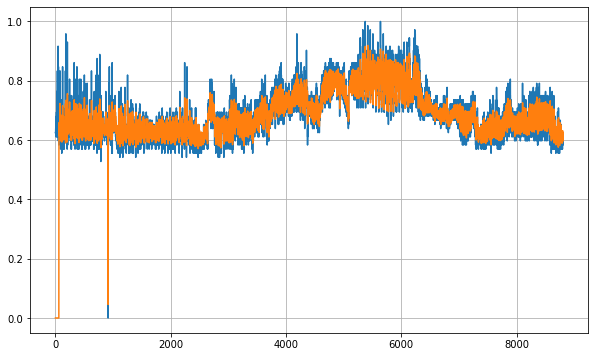

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scaled_band)
plt.plot(res)
plt.grid()

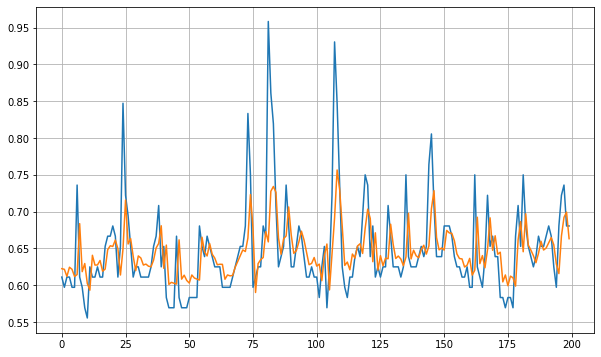

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scaled_band[100:300])
plt.plot(res[100:300])
plt.grid()

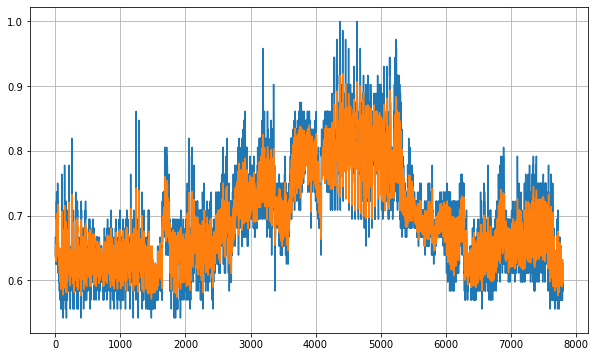

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scaled_band[1000:20000])
plt.plot(res[1000:20000])
plt.grid()

## **Predicitons**

In [ ]:
dataframe_test = pd.read_csv("/content/drive/MyDrive/BandData/2000_all.csv")

In [ ]:
dataframe_test.head()

,File X,File Y,Map X,Map Y,Lat,Lon,B1,B2,B3,B4,B5,B6,class
0,382,163,290505,1197315,10.825246,79.083772,77,66,80,77,45,66,5
1,390,163,290745,1197315,10.825259,79.085966,78,70,67,52,30,57,5
2,391,163,290775,1197315,10.825261,79.086241,78,68,77,59,35,61,5
3,381,163,290475,1197315,10.825244,79.083498,76,63,85,74,38,67,5
4,379,164,290415,1197285,10.824969,79.082951,77,70,59,64,39,57,5


In [ ]:
test_band1 = dataframe_test.iloc[:, 6:7].values

dataframe_total = pd.concat((dataframe[' B1'], dataframe_test[' B1']), axis=0)
band_1_total = dataframe_total[len(dataframe_total)-len(dataframe_test)-time_scale:].values

band_1_total = band_1_total.reshape(-1, 1)
band_1_total = sc.transform(band_1_total)

In [ ]:
X_test = []
for i in range(time_scale, time_scale+len(test_band1)):
  X_test.append(band_1_total[i-time_scale:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_band_1 = model.predict(X_test)
predicted_band_1 = sc.inverse_transform(predicted_band_1)
real_band = dataframe_test.iloc[:, 6:7].values

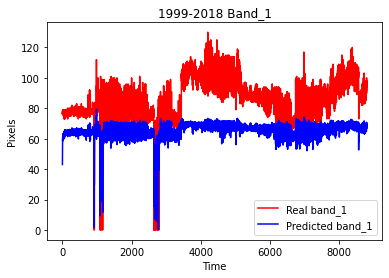

In [ ]:
plt.plot(real_band, color = 'red', label = 'Real band_1')
plt.plot(predicted_band_1, color = 'blue', label = 'Predicted band_1')
plt.title('1999-2018 Band_1')
plt.xlabel('Time')
plt.ylabel('Pixels')
plt.legend()
plt.show()

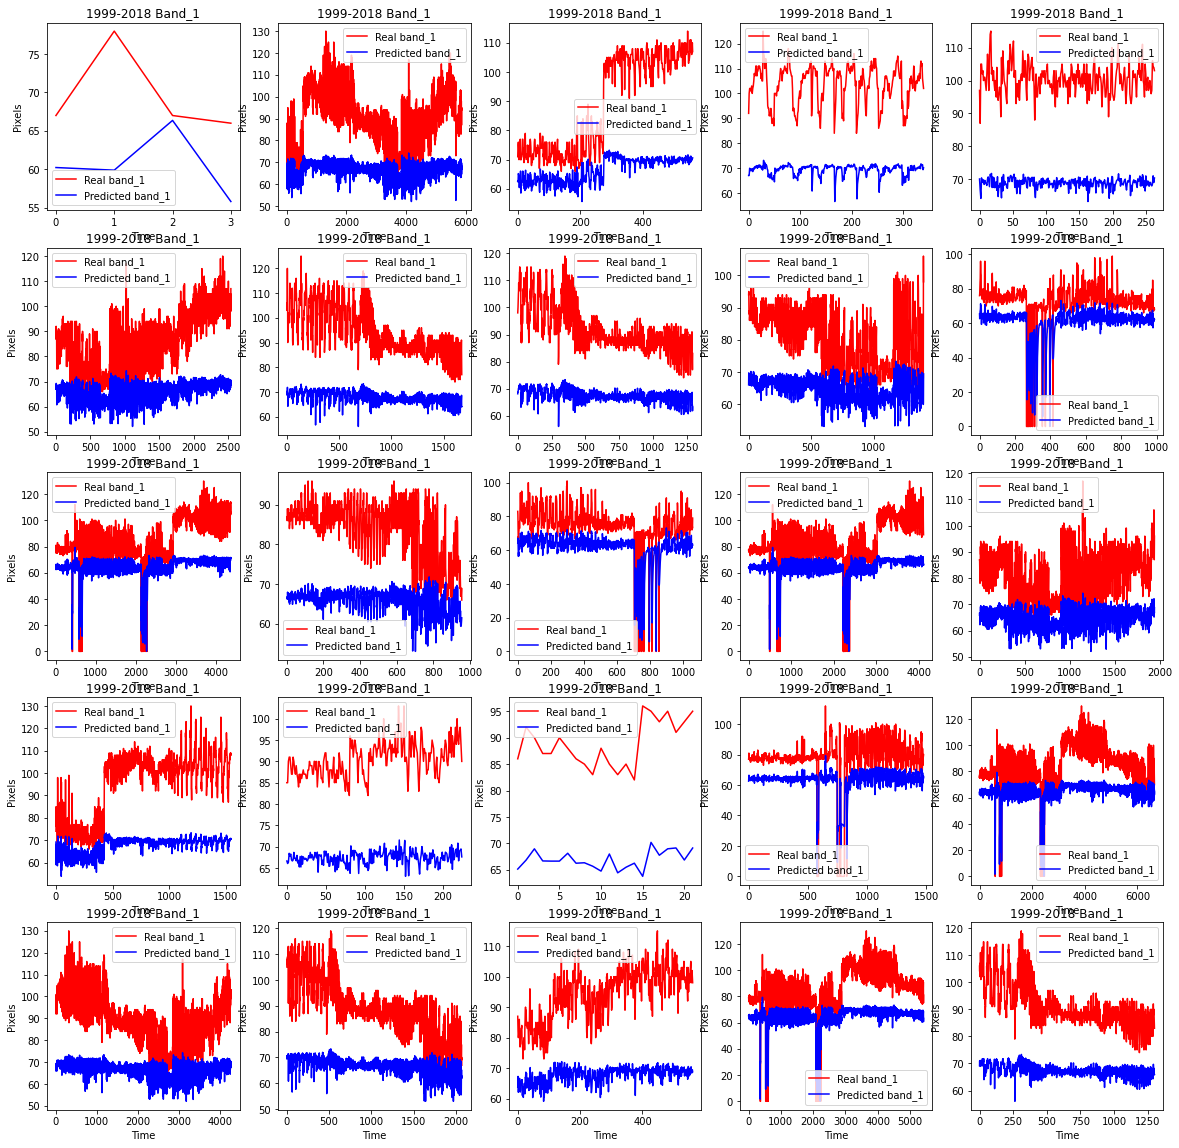

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(25):
  rand1 = random.randint(time_scale, time_scale+len(test_band1))
  rand2 = random.randint(rand1, time_scale+len(test_band1))
  while rand1 > len(test_band1) and rand2 > len(test_band1):
    rand1 = random.randint(time_scale, time_scale+len(test_band1))
    rand2 = random.randint(rand1, time_scale+len(test_band1))
  ax = plt.subplot(5, 5, i+1)
  plt.plot(real_band[rand1:rand2], color = 'red', label = 'Real band_1')
  plt.plot(predicted_band_1[rand1:rand2], color = 'blue', label = 'Predicted band_1')
  plt.title('1999-2018 Band_1')
  plt.xlabel('Time')
  plt.ylabel('Pixels')
  plt.legend()

plt.show()

## **Error analysis**

In [ ]:
error = pd.DataFrame({"Real": real_band.flatten(), "Predicted": predicted_band_1.flatten(), "Error": (real_band-predicted_band_1).flatten()})

In [ ]:
error.head()

,Real,Predicted,Error
0,77,42.989017,34.010983
1,78,49.231838,28.768162
2,78,54.492851,23.507149
3,76,57.325665,18.674335
4,77,57.590309,19.409691


In [ ]:
np.sum(np.square(error['Error']))/len(error['Error'])

541.7364538144817

In [ ]:
np.sum(tf.keras.metrics.mean_squared_error(real_band, predicted_band_1).numpy())/len(real_band)

541.7364803453761